In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import torch
from easydict import EasyDict as edict
import numpy as np
from pathlib import Path

from iterative_sir.sampling_utils.ebm_sampling import mala_dynamics
from iterative_sir.sampling_utils.sir_ais_sampling import sir_independent_dynamics
from iterative_sir.sampling_utils.adaptive_mc import adaptive_sir_correlated_dynamics, ex2_mcmc_mala
from iterative_sir.sampling_utils.distributions import (Distribution, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal,
                           init_independent_normal_scale)
from iterative_sir.sampling_utils.metrics import Evolution, acl_spectrum, ESS

In [15]:
# import matplotlib 

# matplotlib.rcParams.update({'font.size': 15})

In [49]:
import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

In [50]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [58]:
figpath = Path('../figs')

In [51]:
def random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [52]:
def define_target(loc_1_target = -3, loc_2_target = 3, scale_target = 1, dim=100, device='cpu'):
    target_args = edict()
    target_args.device = device
    target_args.num_gauss = 2

    coef_gaussian = 1. / target_args.num_gauss
    target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
    locs = [loc_1_target*torch.ones(dim, dtype = torch.float64).to(device),
        loc_2_target*torch.ones(dim, dtype = torch.float64).to(device)]
    locs_numpy = torch.stack(locs, axis = 0).cpu().numpy()
    target_args.locs = locs
    target_args.covs = [(scale_target**2)*torch.eye(dim, 
                                                    dtype = torch.float64).to(device)]*target_args.num_gauss
    target_args.dim = dim
    target = Gaussian_mixture(target_args)
    return target

In [53]:
def compute_metrics(sample, target, trunc_chain_len=None):
    if trunc_chain_len is not None:
        trunc_sample = sample[(-trunc_chain_len - 1):-1]
    else:
        trunc_sample = sample
    if isinstance(sample, list):
        sample = torch.stack(sample, axis = 0).detach().cpu().numpy()
        trunc_sample = torch.stack(trunc_sample, axis = 0).detach().cpu()
    chain_len, batch_size, dim = sample.shape
        
    locs = target.locs
    evolution = Evolution(None, locs=torch.stack(locs, 0).cpu(), sigma=target.covs[0][0, 0])  

    result_np = trunc_sample.detach().cpu().numpy()
        
    modes_var_arr = []
    modes_mean_arr = []
    hqr_arr = []
    jsd_arr = []
    ess_arr = []
    means_est_1 = torch.zeros(dim)
    means_est_2 = torch.zeros(dim)
    num_found_1_mode = 0
    num_found_2_mode = 0
    num_found_both_modes = 0

    ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...]).detach().cpu().numpy())).mean()

    for i in range(batch_size):
        X_gen = trunc_sample[:, i, :]

        assignment = Evolution.make_assignment(X_gen, evolution.locs, evolution.sigma)
        mode_var = Evolution.compute_mode_std(X_gen, assignment)[0].item()**2
        modes_mean, found_modes_ind = Evolution.compute_mode_mean(X_gen, assignment)

        if 0 in found_modes_ind and 1 in found_modes_ind:
            num_found_both_modes += 1
        if 0 in found_modes_ind:
            num_found_1_mode += 1
            means_est_1 += modes_mean[0]
        if 1 in found_modes_ind:
            num_found_2_mode += 1
            means_est_2 += modes_mean[1]
        
        hqr = Evolution.compute_high_quality_rate(assignment).item()
        jsd = Evolution.compute_jsd(assignment).item()
        
        modes_var_arr.append(mode_var)
        hqr_arr.append(hqr)
        jsd_arr.append(jsd)

    jsd = np.array(jsd_arr).mean()
    modes_var = np.array(modes_var_arr).mean()
    hqr = np.array(hqr_arr).mean()
    #ess = np.mean(ess_arr)
    if num_found_1_mode == 0:
        print("Unfortunalely, no points were assigned to 1st mode, default estimation - zero")
        modes_mean_1_result = np.nan #0.0
    else:
        modes_mean_1_result = (means_est_1/num_found_1_mode).mean().item()
    if num_found_2_mode == 0:
        print("Unfortunalely, no points were assigned to 2nd mode, default estimation - zero")
        modes_mean_2_result = np.nan #0.0
    else:
        modes_mean_2_result = (means_est_2/num_found_2_mode).mean().item()
    if num_found_1_mode == 0 and num_found_2_mode == 0:
        modes_mean_1_result = modes_mean_2_result = trunc_sample.mean().item()
        
    result = dict(jsd=jsd, modes_var=modes_var, hqr=hqr, mode1_mean=modes_mean_1_result, mode2_mean=modes_mean_2_result, fraction_found2_modes=num_found_both_modes/batch_size, fraction_found1_mode=(num_found_1_mode+num_found_2_mode-2*num_found_both_modes)/batch_size, ess=ess)
    return result



In [54]:
from collections import defaultdict
from functools import partial
import time
from typing import Dict

def run_experiment(args: dict, methods_calls: Dict[str, callable]):
    found_both = defaultdict(list)
    ess = defaultdict(list)
    sampling_time = defaultdict(list)
    ess_per_sec = defaultdict(list)
    hqr_dict = defaultdict(list)

    for dim in args.dim:
        print(f'dim = {dim}')
        target = define_target(args.loc_1_target, args.loc_2_target, args.scale_target, dim, device=device)#.log_prob
        proposal = init_independent_normal(args.scale_proposal, dim, device, args.loc_proposal)

        for method_name, call in methods_calls.items():

            start = proposal.sample([args.batch_size])

            s = time.time()
            # hardcode
            if method_name == 'isir':
                out = call(start, target, proposal)
            else:
                out = call(start, target.log_prob, proposal)
            e = time.time()
            elapsed = (e - s) #/ 60
            if isinstance(out, tuple):
                sample = out[0]
            else:
                sample = out
            
            trunc_chain_len = int(0.9 * len(sample))
            result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
            print(method_name, result)
            print(f'Elapsed: {elapsed:.2f} s')

            found_both[method_name].append(result['fraction_found2_modes'])
            ess[method_name].append(result['ess'])
            sampling_time[method_name].append(elapsed)
            ess_per_sec[method_name].append(result['ess'] * trunc_chain_len / elapsed)
            hqr_dict[method_name].append(result['hqr'])
    return found_both, ess, ess_per_sec, hqr_dict

In [55]:
args = edict()
args.loc_1_target = -1.5
args.loc_2_target = 1.5
args.scale_target = 1.

args.scale_proposal = 2
args.loc_proposal = 0

args.dim = np.arange(10, 30, 2)# + 1) #[16, 32, 64, ]

args.batch_size = 200
# args.n_steps = 150

found_both = defaultdict(list)
ess = defaultdict(list)
sampling_time = defaultdict(list)
ess_per_sec = defaultdict(list)
hqr = defaultdict(list)

In [60]:
# equal number of steps (1000)

methods_calls = defaultdict(tuple)

N = 10
n_steps = 1000
mala_steps = 1

method_args = edict()
method_args.n_steps = 1000
method_args.N = N
methods_calls['ISIR'] = partial(sir_independent_dynamics, **method_args)

method_args = edict()
method_args.n_steps = 1000
method_args.grad_step = 1e-2
method_args.eps_scale = (2 * method_args.grad_step)**.5
method_args.adapt_stepsize = True
methods_calls['MALA'] = partial(mala_dynamics, **method_args)

method_args = edict()
method_args.n_steps = 1000 #200
method_args.mala_steps = 1 #5
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = N
method_args.corr_coef = 0.95
method_args.bernoulli_prob_corr = 0.1
method_args.adapt_stepsize = True
methods_calls[r'EX$^2$MCMC MALA'] = partial(ex2_mcmc_mala, **method_args)

found_both_, ess_, ess_per_sec_, hqr_ = run_experiment(args, methods_calls)
found_both.update(found_both_)
ess.update(ess_)
ess_per_sec.update(ess_per_sec_)
hqr.update(hqr_)


dim = 10
ISIR {'jsd': 0.03932161161326803, 'modes_var': 0.7863210505420191, 'hqr': 0.9458499997854233, 'mode1_mean': -1.4275195598602295, 'mode2_mean': 1.4715937376022339, 'fraction_found2_modes': 0.995, 'fraction_found1_mode': 0.005, 'ess': 0.016780712}
Elapsed: 2.42 s
MALA {'jsd': 0.22637477815151213, 'modes_var': 0.937161075936489, 'hqr': 0.948811109662056, 'mode1_mean': -1.5013905763626099, 'mode2_mean': 1.4995757341384888, 'fraction_found2_modes': 0.0, 'fraction_found1_mode': 1.0, 'ess': 0.15985362}
Elapsed: 2.67 s
EX$^2$MCMC MALA {'jsd': 0.02574023826047778, 'modes_var': 0.9384553372042612, 'hqr': 0.9487388890981674, 'mode1_mean': -1.4972412586212158, 'mode2_mean': 1.4956995248794556, 'fraction_found2_modes': 1.0, 'fraction_found1_mode': 0.0, 'ess': 0.02973078}
Elapsed: 5.02 s
dim = 12
ISIR {'jsd': 0.07113196276535745, 'modes_var': 0.6322371467585988, 'hqr': 0.9324722212553024, 'mode1_mean': -1.3913637399673462, 'mode2_mean': 1.3968778848648071, 'fraction_found2_modes': 0.955, 'f

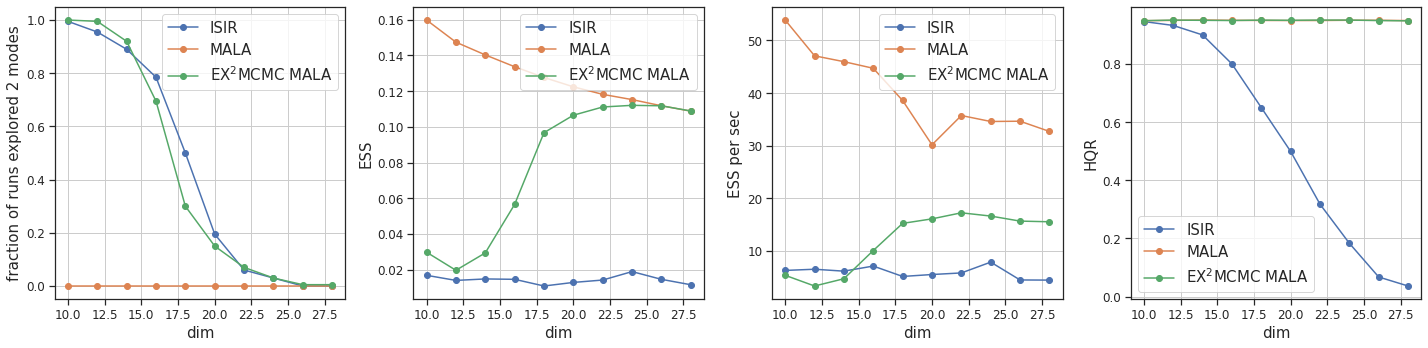

In [61]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

import matplotlib.pyplot as plt

SMALL_SIZE = 12 #8
MEDIUM_SIZE = 15 #10
BIGGER_SIZE = 15 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



for method_name, arr in found_both.items():
    axs[0].plot(args.dim, arr, label=method_name, marker='o')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('fraction of runs explored 2 modes')
axs[0].grid()
axs[0].legend()


for method_name, arr in ess.items():
    axs[1].plot(args.dim, arr, label=method_name, marker='o')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('ESS')
axs[1].grid()
axs[1].legend()

for method_name, arr in ess_per_sec.items():
    axs[2].plot(args.dim, arr, label=method_name, marker='o')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS per sec')
axs[2].grid()
axs[2].legend()

for method_name, arr in hqr.items():
    axs[3].plot(args.dim, arr, label=method_name, marker='o')
axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')
axs[3].grid()
axs[3].legend()

plt.savefig(Path(figpath, '2_gaussians.pdf'))
fig.tight_layout()
plt.show()

In [14]:
# equal sample size (1000) 

methods_calls = defaultdict(tuple)

method_args = edict()
method_args.n_steps = 1000
method_args.mala_steps = 5
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 10
method_args.corr_coef = 0.95
method_args.bernoulli_prob_corr = 0.1
method_args.adapt_stepsize = True
methods_calls[r'EX$2$MCMC MALA'] = partial(ex2_mcmc_mala, **method_args)
method_args.trunc_chain_len = 900

found_both_, ess_, ess_per_sec_, hqr_ = run_experiment(args, methods_calls)
found_both.update(found_both_)
ess.update(ess_)
ess_per_sec.update(ess_per_sec_)
hqr.update(hqr_)


dim = 10
ex2_mcmc_mala {'jsd': 0.02475481113884598, 'modes_var': 0.9393170069834285, 'hqr': 0.9503555524349213, 'mode1_mean': -1.5001252889633179, 'mode2_mean': 1.5000964403152466, 'fraction_found2_modes': 1.0, 'fraction_found1_mode': 0.0, 'ess': 0.03382712}
Elapsed: 20.69 s
dim = 12
ex2_mcmc_mala {'jsd': 0.03665029475931078, 'modes_var': 0.9482018376802033, 'hqr': 0.9493388867378235, 'mode1_mean': -1.4990872144699097, 'mode2_mean': 1.5002026557922363, 'fraction_found2_modes': 1.0, 'fraction_found1_mode': 0.0, 'ess': 0.02098338}
Elapsed: 24.36 s
dim = 14
ex2_mcmc_mala {'jsd': 0.06938654929865151, 'modes_var': 0.9497292924565867, 'hqr': 0.9499833324551582, 'mode1_mean': -1.4972270727157593, 'mode2_mean': 1.501194715499878, 'fraction_found2_modes': 0.925, 'fraction_found1_mode': 0.075, 'ess': 0.055303082}
Elapsed: 30.56 s
dim = 16
ex2_mcmc_mala {'jsd': 0.11447163217701017, 'modes_var': 0.9552926108898993, 'hqr': 0.9510666659474373, 'mode1_mean': -1.5001052618026733, 'mode2_mean': 1.49932

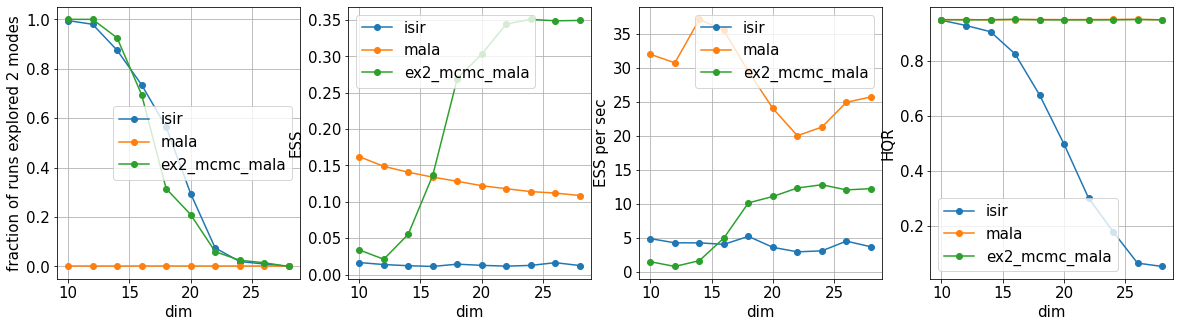

In [15]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

for method_name, arr in found_both.items():
    axs[0].plot(args.dim, arr, label=method_name, marker='o')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('fraction of runs explored 2 modes')
axs[0].grid()
axs[0].legend()


for method_name, arr in ess.items():
    axs[1].plot(args.dim, arr, label=method_name, marker='o')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('ESS')
axs[1].grid()
axs[1].legend()

for method_name, arr in ess_per_sec.items():
    axs[2].plot(args.dim, arr, label=method_name, marker='o')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS per sec')
axs[2].grid()
axs[2].legend()

for method_name, arr in hqr.items():
    axs[3].plot(args.dim, arr, label=method_name, marker='o')
axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')
axs[3].grid()
axs[3].legend()

#plt.savefig()
plt.show()

In [16]:
# equal number of steps (5000)

methods_calls = defaultdict(tuple)

method_args = edict()
method_args.n_steps = 5000
method_args.N = 10
methods_calls['ISIR'] = partial(sir_independent_dynamics, **method_args)
method_args.trunc_chain_len = 4500

method_args = edict()
method_args.n_steps = 5000
method_args.grad_step = 1e-2
method_args.eps_scale = (2 * method_args.grad_step)**.5
method_args.adapt_stepsize = True
methods_calls['MALA'] = partial(mala_dynamics, **method_args)
method_args.trunc_chain_len = 4500

found_both_, ess_, ess_per_sec_, hqr_ = run_experiment(args, methods_calls)
found_both.update(found_both_)
ess.update(ess_)
ess_per_sec.update(ess_per_sec_)
hqr.update(hqr_)


dim = 10
isir {'jsd': 0.024373721652664243, 'modes_var': 0.8930172456385332, 'hqr': 0.9495455572009086, 'mode1_mean': -1.4846689701080322, 'mode2_mean': 1.4837449789047241, 'fraction_found2_modes': 1.0, 'fraction_found1_mode': 0.0, 'ess': 0.010485567}
Elapsed: 14.28 s
mala {'jsd': 0.2261020193248987, 'modes_var': 0.9422935561912433, 'hqr': 0.9500588881969452, 'mode1_mean': -1.5008362531661987, 'mode2_mean': 1.498626947402954, 'fraction_found2_modes': 0.0, 'fraction_found1_mode': 1.0, 'ess': 0.25749645}
Elapsed: 19.23 s
dim = 12
isir {'jsd': 0.040046607665717604, 'modes_var': 0.834422004912673, 'hqr': 0.9428111121058464, 'mode1_mean': -1.455510139465332, 'mode2_mean': 1.4605799913406372, 'fraction_found2_modes': 0.995, 'fraction_found1_mode': 0.005, 'ess': 0.0069917836}
Elapsed: 14.32 s
mala {'jsd': 0.22614056393504142, 'modes_var': 0.9466948032363288, 'hqr': 0.949876665174961, 'mode1_mean': -1.5003381967544556, 'mode2_mean': 1.500200867652893, 'fraction_found2_modes': 0.0, 'fraction_fo

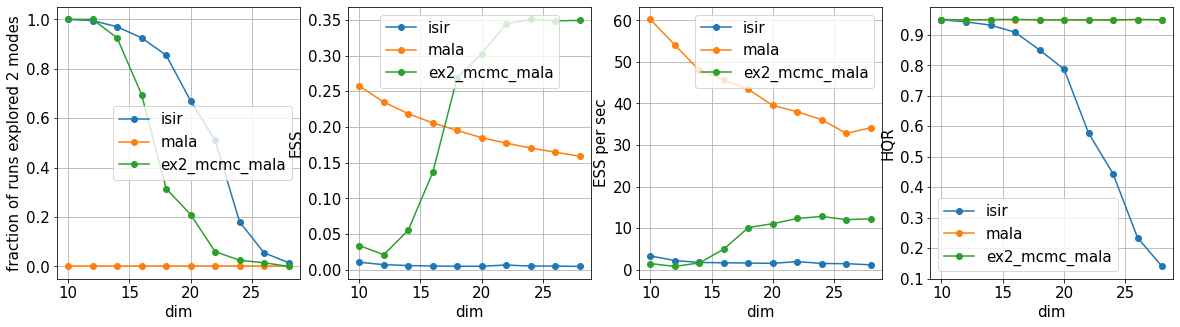

In [17]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

for method_name, arr in found_both.items():
    axs[0].plot(args.dim, arr, label=method_name, marker='o')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('fraction of runs explored 2 modes')
axs[0].grid()
axs[0].legend()


for method_name, arr in ess.items():
    axs[1].plot(args.dim, arr, label=method_name, marker='o')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('ESS')
axs[1].grid()
axs[1].legend()

for method_name, arr in ess_per_sec.items():
    axs[2].plot(args.dim, arr, label=method_name, marker='o')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS per sec')
axs[2].grid()
axs[2].legend()

for method_name, arr in hqr.items():
    axs[3].plot(args.dim, arr, label=method_name, marker='o')
axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')
axs[3].grid()
axs[3].legend()

#plt.savefig()
plt.show()

In [18]:
args = edict()
args.loc_1_target = -1.5
args.loc_2_target = 1.5
args.scale_target = 1.

args.scale_proposal = 2
args.loc_proposal = 0

args.dim = [16]

args.batch_size = 200
args.n_steps = 150

In [19]:
dim = args.dim[0]

In [20]:
target = define_target(args.loc_1_target, args.loc_2_target, args.scale_target, dim, device=device)#.log_prob
proposal = init_independent_normal(args.scale_proposal, dim, device, args.loc_proposal)

In [21]:
method_args = edict()
method_args.n_steps = 1000
method_args.N = 6

start = proposal.sample([args.batch_size])
sample = sir_independent_dynamics(start, target, proposal, **method_args)

In [22]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.19586239956726786, 'modes_var': nan, 'hqr': 0.7555777790024877, 'mode1_mean': -1.2401094436645508, 'mode2_mean': 1.2340672016143799, 'fraction_found2_modes': 0.65, 'fraction_found1_mode': 0.345, 'ess': 0.011412215}


In [23]:
method_args = edict()
method_args.n_steps = 5000
method_args.grad_step = 1e-2
method_args.eps_scale = (2 * method_args.grad_step)**.5

start = proposal.sample([args.batch_size])
sample, acceptance = mala_dynamics(start, target.log_prob, proposal, **method_args, acceptance_rule='Hastings', adapt_stepsize=True)

In [24]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.22586419880390168, 'modes_var': 0.9494975209700378, 'hqr': 0.951233334839344, 'mode1_mean': -1.4988445043563843, 'mode2_mean': 1.4999927282333374, 'fraction_found2_modes': 0.0, 'fraction_found1_mode': 1.0, 'ess': 0.13321367}


In [25]:
method_args = edict()
method_args.n_steps = 1000
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 10
method_args.corr_coef = 0 #0.9
method_args.bernoulli_prob_corr = 0 #0.5


start = proposal.sample([args.batch_size])
sample, acceptance, _ = ex2_mcmc_mala(start, target.log_prob, proposal, **method_args, adapt_stepsize=True)

In [26]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.1192005862807855, 'modes_var': 0.9549505037709417, 'hqr': 0.9492666631937027, 'mode1_mean': -1.4993212223052979, 'mode2_mean': 1.498178482055664, 'fraction_found2_modes': 0.665, 'fraction_found1_mode': 0.335, 'ess': 0.14716037}


In [27]:
method_args = edict()
method_args.n_steps = 1000
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 10
method_args.corr_coef = 0.95
method_args.bernoulli_prob_corr = 0.1


start = proposal.sample([args.batch_size])
sample, acceptance, _ = ex2_mcmc_mala(start, target.log_prob, proposal, **method_args, adapt_stepsize=True)

In [28]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.13144266293384135, 'modes_var': 0.9541479036882964, 'hqr': 0.949961110651493, 'mode1_mean': -1.4993059635162354, 'mode2_mean': 1.4997081756591797, 'fraction_found2_modes': 0.61, 'fraction_found1_mode': 0.39, 'ess': 0.16427025}


In [29]:
method_args = edict()
method_args.n_steps = 1000
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 10
method_args.corr_coef = 0.1
method_args.bernoulli_prob_corr = 0.95


start = proposal.sample([args.batch_size])
sample, acceptance, _ = ex2_mcmc_mala(start, target.log_prob, proposal, **method_args, adapt_stepsize=True)

In [30]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.1234020827524364, 'modes_var': 0.9548153888368553, 'hqr': 0.9504777792096138, 'mode1_mean': -1.5010615587234497, 'mode2_mean': 1.4987761974334717, 'fraction_found2_modes': 0.635, 'fraction_found1_mode': 0.365, 'ess': 0.1536296}


In [31]:
# alpha = 0.1

# start = proposal.sample([batch_size])
# sample = adaptive_sir_correlated_dynamics(start, target, proposal, n_steps, N, alpha, flow)